In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from src.models.rae_chars import RAEChars as RAE
from src.models.vrae_chars import VRAEChars as VRAE
from src.models.iaf_chars import IAFChars as IAF

from src.models.vrae_chars import VariationalInference

from src.data.toy import ToyData
from src.data.common import get_loader
from src.models.common import CriterionTrainer, OneHotPacked, VITrainer

from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss

import numpy as np

seed = 42
torch.set_deterministic(True)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Defining data

In [2]:
data_parameters = {
    "num_classes" : 4,
    "max_length" : 30,
    "min_length" : 2,
    "error_prob" : 0.1,
}

class_names = 'abcdefghijklmnopqrstuvwxyz'
end_string = '$'
missing = '0'

alphabet = missing + class_names[:data_parameters["num_classes"]] + end_string

batch_size = 100
max_epochs = 50

train_data = ToyData(num_observations=10_000, **data_parameters)
validation_data = ToyData(num_observations=1_000, **data_parameters)
test_data = ToyData(num_observations=1_000, **data_parameters)

# Recurrent autoencoder

In [5]:
rae = RAE(
    input_dim=num_classes + 2,
    embedding_dim=num_classes + 2,
    latent_features=2,
    encoder_hidden_size=32,
    decoder_hidden_size=32,
    embedding=OneHotPacked(num_classes+2),
)

optimizer_parameters = {
    "lr": 0.02,
}

criterion = CrossEntropyLoss(reduction="sum")
optimizer = Adam(rae.parameters(), **optimizer_parameters)

class CriterionTrainerNoCache(CriterionTrainer):

    def save_checkpoint(self):
        pass

    def restore_checkpoint(self):
        pass

mt = CriterionTrainerNoCache(
    criterion=criterion,
    model=rae,
    optimizer=optimizer,
    batch_size=batch_size,
    max_epochs=max_epochs,
    training_data=train_data,
    validation_data=test_data,
)

mt.train(progress_bar=True)

NameError: name 'num_classes' is not defined

In [22]:
num_tests = 1000
x_test = next(iter(get_loader(test_data, batch_size=num_tests)))

output_rae = rae(x_test)

# Sample from observation model and pack, then pad
sample_rae_padded, sequence_lengths = pad_packed_sequence(output_rae)
sample_rae_padded = sample_rae_padded.argmax(dim=2)

target_padded, _ = pad_packed_sequence(x_test)

for i, length, _ in zip(range(num_tests), sequence_lengths, range(16)):

    decoded_rae = sample_rae_padded[:, i][:length]
    target = target_padded[:, i][:length]

    print("   RAE: " + "".join(alphabet[i] for i in decoded_rae))
    print("TARGET: " + "".join(alphabet[i] for i in target))

    print("")

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: dddddddddddddddddd00ddddddddd0$

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: dddddddddddddd0ddddddddddddddd$

   RAE: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa$
TARGET: aaaaaaaaaaaaaaaaaaa0a0aaa0aaaa$

   RAE: cccccccccccccccccccccccccccccc$
TARGET: cccccccccccccccc0ccc000ccccccc$

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: 0ddddddddddddddddddddddddddddd$

   RAE: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa$
TARGET: aaaaaaa0aaaaaaaaa0aaaaaaaaaaaa$

   RAE: cccccccccccccccccccccccccccccc$
TARGET: 0ccccccccccccc0cccccccc0cccccc$

   RAE: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa$
TARGET: aaaaa0aaa0aaaaaaaaaaaaaa0aaaaa$

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: bbbbbbbb00bbbbbbbbbbbb0bbbbb00$

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: d0ddddddddddddddd0dddddddd0ddd$

   RAE: ddbdddbbbbbbbbbbbbbbbbbbbbbb$$$
TARGET: bbbbb00bbbb0bbbbbbbbbbbbbbb0b0$

   RAE: cccccccccccccccccccccccccccccc$
TARGET: cc0cccc0ccccccccccc0cccccccccc$

   RAE: ddbdddbbbbbbbbbbbbbb

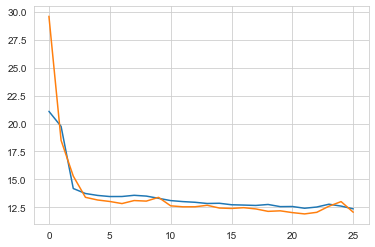

In [23]:
import matplotlib.pyplot as plt
plt.plot(mt.training_loss)
plt.plot(mt.validation_loss)

<AxesSubplot:>

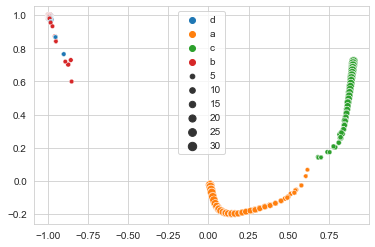

In [24]:
import seaborn as sns

sns.set_style("whitegrid")
x, y = rae.encoder(
    rae.embedding(x_test)
    ).detach().numpy().T

lengths = sequence_lengths.numpy()
values = [t[0] for t in test_data.values]

target_colors = []

for i in range(len(lengths)):
    arr = target_padded[:,i].numpy()
    target_colors.append(alphabet[next(x for x in arr if x != 0)])

data = {
    'x' : x,
    'y' : y,
    'length' : lengths,
    'value' : target_colors,
}

sns.scatterplot(
    x=data['x'], 
    y=data['y'], 
    size=data['length'], 
    hue=data['value']
    )

#sequence_lengths

# Variational recurrent autoencoder

In [7]:
vrae = VRAE(
    input_dim=num_classes + 2,
    embedding_dim=num_classes + 2,
    latent_features=2,
    encoder_hidden_size=32,
    decoder_hidden_size=32,
    embedding=OneHotPacked(num_classes+2),
)

optimizer_parameters = {
    "lr": 0.05,
}

vi = VariationalInference()
optimizer = Adam(vrae.parameters(), **optimizer_parameters)

class VITrainerNoCache(VITrainer):

    def save_checkpoint(self):
        pass

    def restore_checkpoint(self):
        pass

mt = VITrainerNoCache(
    vi=vi,
    model=vrae,
    optimizer=optimizer,
    batch_size=batch_size,
    max_epochs=max_epochs,
    training_data=train_data,
    validation_data=test_data,
)

mt.train(progress_bar=True)

100%|██████████| 200/200 [00:03<00:00, 53.07it/s]Epoch 1 done!
T. loss: 15.681732287406922
V. loss: 15.994636392593383

100%|██████████| 200/200 [00:03<00:00, 52.99it/s]Epoch 2 done!
T. loss: 15.567822098731995
V. loss: 15.26741008758545

100%|██████████| 200/200 [00:04<00:00, 49.03it/s]Epoch 3 done!
T. loss: 15.53846034526825
V. loss: 15.318958234786987

100%|██████████| 200/200 [00:03<00:00, 51.42it/s]Epoch 4 done!
T. loss: 15.524154925346375
V. loss: 15.27089056968689

100%|██████████| 200/200 [00:03<00:00, 53.20it/s]Epoch 5 done!
T. loss: 15.516302046775818
V. loss: 15.293301677703857

100%|██████████| 200/200 [00:03<00:00, 53.23it/s]Epoch 6 done!
T. loss: 15.515506353378296
V. loss: 15.267783260345459

100%|██████████| 200/200 [00:03<00:00, 52.35it/s]Epoch 7 done!
T. loss: 15.51957510471344
V. loss: 15.249430942535401

100%|██████████| 200/200 [00:03<00:00, 53.47it/s]Epoch 8 done!
T. loss: 15.50902705669403
V. loss: 15.22569031715393

100%|██████████| 200/200 [00:03<00:00, 53.37it

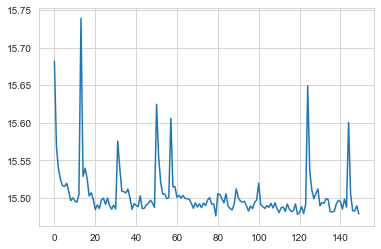

In [8]:
import matplotlib.pyplot as plt
plt.plot(mt.training_loss)

In [9]:
num_tests = 100
x_test = next(iter(get_loader(test_data, batch_size=num_tests)))

output_vrae = vrae(x_test)

# Sample from observation model and pack, then pad
sample_vrae_packed = PackedSequence(
    output_vrae['px'].sample(),
    x_test.batch_sizes

)
sample_vrae_padded, sequence_lengths = pad_packed_sequence(sample_vrae_packed)

target_padded, _ = pad_packed_sequence(x_test)

for i, length, _ in zip(range(num_tests), sequence_lengths, range(16)):

    decoded_vrae = sample_vrae_padded[:, i][:length]
    target = target_padded[:, i][:length]

    print("   RAE: " + "".join(alphabet[i] for i in decoded_vrae))
    print("TARGET: " + "".join(alphabet[i] for i in target))

    print("")

   RAE: fab$ch0d$$$
TARGET: eeeeeeeeee$

   RAE: cfccgh$$$f$
TARGET: bbbbbbbbbb$

   RAE: dfaa$d0ae$$
TARGET: aaaa0aa0aa$

   RAE: hceacb0b$0$
TARGET: d0dddddddd$

   RAE: ee$e0fbgba$
TARGET: ccccc0cccc$

   RAE: acbahff$$f$
TARGET: dddddd0ddd$

   RAE: hhggdefd$e$
TARGET: 0e0eeeeeee$

   RAE: ahdgcgd$d$$
TARGET: gggggggggg$

   RAE: fee$0b$a$b$
TARGET: dddddddddd$

   RAE: 0gegecf0$g$
TARGET: dddddddddd$

   RAE: efcdge0$0c
TARGET: gggg0ggg0$

   RAE: 0ehecbfe$$
TARGET: aaaaaaaa0$

   RAE: fbabg0$f$d
TARGET: bbbbbb0bb$

   RAE: gfg0b$hbec
TARGET: f0fffffff$

   RAE: hbhdb$dac$
TARGET: eeeeeeeee$

   RAE: egb$fcdc$c
TARGET: ffffff0ff$



In [10]:
mu, log_sigma = vrae.encoder(vrae.embedding(x_test))
mu = mu.detach().numpy()

<AxesSubplot:>

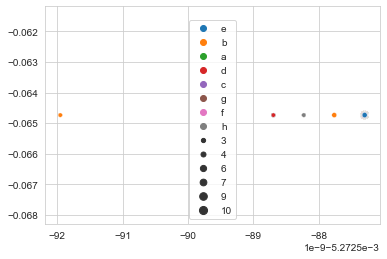

In [11]:
import seaborn as sns

lengths = sequence_lengths.numpy()
values = [t[0] for t in test_data.values]

target_colors = []

x, y = mu.T

for i in range(len(lengths)):
    arr = target_padded[:,i].numpy()
    target_colors.append(alphabet[next(x for x in arr if x != 0)])

data = {
    'x' : x,
    'y' : y,
    'length' : lengths,
    'value' : target_colors,
}

sns.scatterplot(
    x=data['x'], 
    y=data['y'], 
    size=data['length'], 
    hue=data['value']
    )

In [12]:
vrae.prior_params

tensor([[0., 0., 0., 0.]])